In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from scipy.stats import norm

In [2]:
# For reproducible results
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Task 1 - 1D diffusion process

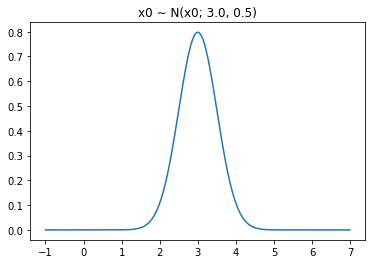

In [3]:
# x0 ∼ N(x0; m, p)
m = 3.0
p = 0.5

# Plot distribution of x0
x_axis = np.arange(-1, 7, 0.01)
plt.title(f"x0 ∼ N(x0; {m}, {p})")
plt.plot(x_axis, norm.pdf(x_axis, m, p))
plt.show()

In [4]:
# Iteratively runs forward diffusion on x0 for T timesteps
# returns: [x0, ... , xT]
def forward_diffuse(x0, T, Bt=0.25):
    xts = [x0]
    xt_prev = x0
    for i in range(T):
        ut = np.sqrt(1 - Bt) * xt_prev
        sigmat = np.sqrt(Bt)               # Bt*I = Bt*1 in the one dimensional case
        xt = np.random.normal(ut, sigmat)  # Using formula (1) from the project description; N.B. std instead of var since this is expected numpy arg
        xts.append(xt)
        xt_prev = xt
    return xts

In [5]:
# Uses closed formula to instantly compute xT from x0
# returns: xT
def forward_diffuse_closed(x0, T, Bt=0.25):
    at = 1 - Bt
    at_prod = np.power(at, T)
    uT = np.sqrt(at_prod) * x0
    sigmaT = np.sqrt(1 - at_prod)
    return np.random.normal(uT, sigmaT)

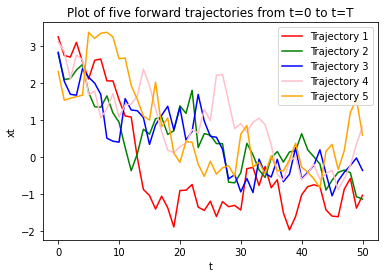

In [6]:
# Visualizing a few forward trajectories
T = 50
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    x0 = np.random.normal(m, p)
    xts = forward_diffuse(x0, T)
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five forward trajectories from t=0 to t=T')  
plt.show()

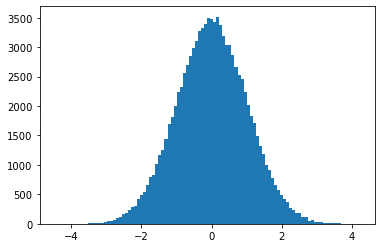

mean: 0.008170375464225088
std: 1.001863117753053


In [7]:
# Visualize the distrubution of xT, approximated from n trajectories
n = 100000    # more samples => better approximation => use closed formula for more efficient computation
xTs = []
for i in range(n):
    x0 = np.random.normal(m, p)
    xT = forward_diffuse_closed(x0, T)
    xTs.append(xT)

plt.hist(xTs, 100)
plt.show()

# Also compute mean and std of xT
print(f"mean: {np.mean(xTs)}\nstd: {np.std(xTs)}")

In [8]:
# Iteratively computes the reverse process, as a function of xt, x0, and t
# returns: [xt, ..., x0] where xi, i<t are the backward trajected values
def backward_diffuse(xt, t, x0, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        at_prod = np.power(at, t)
        c1 = np.sqrt(at)*(1-at_prod/at) / (1-at_prod)
        c2 = np.sqrt(at_prod/at)*Bt / (1-at_prod)
        ut_tilde = c1*xt + c2*x0
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

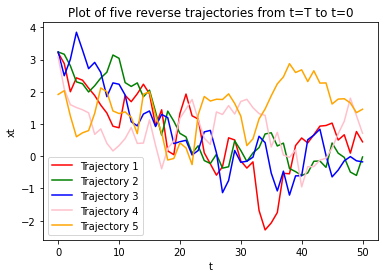

In [9]:
# Visualizing a few reverse trajectories
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    xts_reversed = backward_diffuse(xT, T, x0)
    xts = list(reversed(xts_reversed))    # just for plot, since ts is not reversed
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five reverse trajectories from t=T to t=0')  
plt.show()

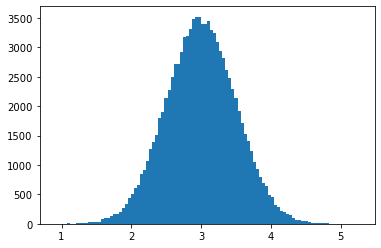

mean: 2.9981123694280862
std: 0.4987826034155103


In [10]:
# Visualize the distrubution of x0, approximated from n reverse trajectories
n = 100000    # more samples => better approximation => TODO: closed formula?
x0s = []
for i in range(n):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    x0_prim = backward_diffuse(xT, T, x0)[-1]   # should be equal to x0
    x0s.append(x0_prim)

plt.hist(x0s, 100)
plt.show()

# Also compute mean and std of x0
print(f"mean: {np.mean(x0s)}\nstd: {np.std(x0s)}")

## Task 2 - Learning a neural network to predict shapes from noise

In [11]:
# Returns the points in a txt file as a 2D ndarray
def read_points(file):
    with open(file, 'r') as f:
        lines = [line.rstrip('\n').split() for line in f]  # 2D array of shape [n, 2] with the point values as strings
        pts = np.zeros([len(lines), 2])
        for i, (x,y) in enumerate(lines):
            pts[i, 0] = float(x)
            pts[i, 1] = float(y)
        return pts

<function matplotlib.pyplot.show(close=None, block=None)>

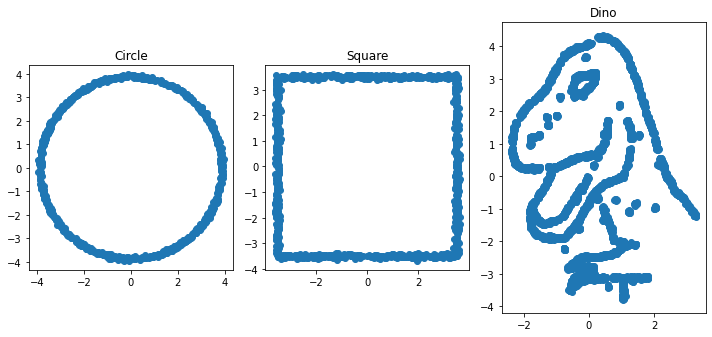

In [12]:
data_path = 'data'
circle_pts = read_points(os.path.join(data_path, 'circle_pts.txt'))
square_pts = read_points(os.path.join(data_path, 'square_pts.txt'))
dinohead_pts = read_points(os.path.join(data_path, 'dinohead_pts.txt'))

# Plot the original shapes
fig, axes = plt.subplots(1, 3, figsize=(10,10))
axes[0].scatter(circle_pts[:, 0], circle_pts[:, 1])
axes[0].set_title('Circle')
axes[0].set_aspect('equal')
axes[1].scatter(square_pts[:, 0], square_pts[:, 1])
axes[1].set_title('Square')
axes[1].set_aspect('equal')
axes[2].scatter(dinohead_pts[:, 0], dinohead_pts[:, 1])
axes[2].set_title('Dino')
axes[2].set_aspect('equal')
plt.tight_layout()
plt.show

In [13]:
# Learning constants
epochs = 50
T = 50
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# Our Neural Network model
class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        self.linear1 = torch.nn.Linear(3, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, 64)
        self.linear4 = torch.nn.Linear(64, 2)
        self.activation = torch.nn.ReLU()

    def forward(self, xt, t):
        x = torch.cat((xt, t), dim=1)  # concatenate point xt with its time t 
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)     # no activation at output, since the noise e is continuous and possibly non-negaive
        return x  

In [15]:
# Uses closed formula to instantly compute xt from x0 and sampled noise e
# Works with x0 of any shape. All computed within torch, to be used directly in training loop
# returns: xt
def forward_diffuse_closed_torch(x0, t, e, Bt=0.25):
    at = torch.tensor([[1 - Bt]], device=device)
    at_prod = torch.pow(at, t)
    ut = torch.sqrt(at_prod) * x0
    sigmat = torch.sqrt(1 - at_prod)
    return ut + sigmat*e

In [16]:
# Reverse sample a point from gaussian noise, given trained model and timestep T
# returns: reverse sampled x0
def sample_pt(model, T):
    xT = torch.randn((1,2), device=device)  # Sample xT from gaussian noise
    
    t = T
    xt = xT 
    Bt = 0.25
    at = 1 - Bt
    # reverse sample until we get xt=x0
    while (t > 0):
        t_tensor = torch.tensor([[t]], device=device).float()
        et = model(xt, t_tensor) # predict noise
        at_prod = torch.pow(at, t_tensor)
        ut_tilde = torch.sqrt(torch.tensor(1/at)) * (xt - (1-at)/(torch.sqrt(1-at_prod))*et)
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = torch.normal(ut_tilde, torch.sqrt(Bt_tilde))  # Compute p( x(t-1) | x(t), x(0) )
        t -= 1
        xt = xt_prev

    return xt

# Samples n_points points using provided model, and plots the scatter plot
def sample_and_scatter(model, T, n_points):
    sample_pts = [sample_pt(model, T).cpu().detach().numpy() for _ in range(n_points)]  # generate n_points points
    sample_pts = np.stack(sample_pts).reshape(n_points, 2)                              # reshape to [[pt0], [pt1], ...]
    plt.scatter(sample_pts[:, 0], sample_pts[:, 1])

In [17]:
# Set up model training
model = MLP()
model.to(device)
dataloader = DataLoader(circle_pts, batch_size=batch_size, shuffle=True)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(epochs):
    
    running_loss = 0.0
    n_batches = len(dataloader)
    for step, batch in enumerate(dataloader):
        
        # Transfers batch from cpu to device (needed when using gpu)
        batch = batch.float().to(device)   # also convert to float32 since this is torch default
        
        # Reset gradients
        optimizer.zero_grad()

        # Sample timesteps, noise, and apply forward diffusion
        t = torch.randint(0, T, (batch.shape[0], 1), device=device).float()
        e = torch.randn_like(batch, device=device) # noise; tensor of same shape as batch, with values sampled from N(0,1)
        pts_diffused = forward_diffuse_closed_torch(batch, t, e)

        # Predict the noise from diffused points and timesteps
        e_pred = model(pts_diffused, t)
        
        # Compute loss and graidents
        loss = loss_fn(e_pred, e)
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Print loss at end of epoch
        running_loss += loss.item()
        if (step+1 == n_batches):
            print('epoch {} loss: {}'.format(epoch+1, running_loss/n_batches))
            running_loss = 0.0

epoch 1 loss: 0.9397179707884789
epoch 2 loss: 0.398898474406451
epoch 3 loss: 0.22965839854441583
epoch 4 loss: 0.20995506108738482
epoch 5 loss: 0.211263392935507
epoch 6 loss: 0.19378804205916822
epoch 7 loss: 0.1930574388243258
epoch 8 loss: 0.1861303811892867
epoch 9 loss: 0.21670736325904727
epoch 10 loss: 0.20665707322768867
epoch 11 loss: 0.22329625790007412
epoch 12 loss: 0.19124182785162702
epoch 13 loss: 0.198667973279953
epoch 14 loss: 0.16127869358751923
epoch 15 loss: 0.17275207792408764
epoch 16 loss: 0.19709829986095428
epoch 17 loss: 0.21993547584861517
epoch 18 loss: 0.15975655254442245
epoch 19 loss: 0.1702409980352968
epoch 20 loss: 0.17643467499874532
epoch 21 loss: 0.19070247909985483
epoch 22 loss: 0.15816877514589578
epoch 23 loss: 0.17805431969463825
epoch 24 loss: 0.16864243266172707
epoch 25 loss: 0.14798264997079968
epoch 26 loss: 0.1861676883418113
epoch 27 loss: 0.1997708845883608
epoch 28 loss: 0.1718221982009709
epoch 29 loss: 0.16015950054861605
epoch 3

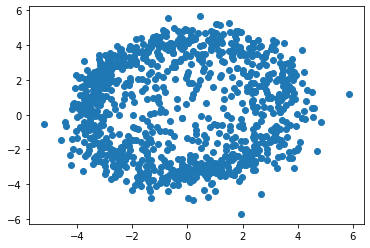

In [18]:
sample_and_scatter(model, T, 1000)

## Drafts (TODO: remove)

In [19]:
# Iteratively computes the reverse process, as a function of xt and t 
# (x0 is actually ignored since it can be represented as a function of xt, at_prod and et)*
# returns: [xt, ..., x0]
def backward_diffuse(xt, t, x0=None, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        et = np.random.normal(0, 1)   # For representing x0 and simplifying formula for ut_tilde
        at_prod = np.power(at, t)
        ut_tilde = (1/at) * (xt - (1-at)/(np.sqrt(1-at_prod))*et)
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

# *TODO: reversed trajectored x0:s are huge! something not right in representation?